In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import FashionMNIST
from torchvision import transforms

from random import randint
from tqdm import tqdm

import matplotlib.pyplot as plt

In [11]:
print(torch.backends.mps.is_available())
#device = torch.device("cpu")
device = torch.device("cpu")

False


In [3]:
t = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset_train = FashionMNIST(root="../datasets/", train=True, download=True, transform=t)
dataset_test = FashionMNIST(root="../datasets/", train=False, download=True, transform=t)

In [4]:
train_dataloader = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=dataset_test, batch_size=10000, shuffle=False)

In [5]:
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(11, 11), stride=(4, 4)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,5), padding=(2,2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3,3), stride=(2,2)),
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [12]:
device = torch.device(device)
model = alexnet().to(device)

In [13]:
N_EPOCHS = 5

B_EPOCHS = int(60_000 / 32)

optim = torch.optim.SGD(params=model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss()
#loss_fn = nn.CrossEntropyLoss()
def acc_fn(pred, target):
  return (pred.argmax(dim=1)==target).sum()

In [ ]:
losses = []
accs = []

prog_bar = tqdm(range(N_EPOCHS))

for e in prog_bar:
    for i, (x, y) in enumerate(train_dataloader):
        optim.zero_grad()
        pred = model(x.to(device))

        loss = loss_fn(pred, y.to(device))
        losses.append(loss.item()/32)

        acc = acc_fn(pred.detach().cpu(), y.detach().cpu())
        accs.append(acc.item()/32)

        loss.backward()
        optim.step()
        if i % 150 == 0: 
            print(f"Epoch: {e} --- {i}/{B_EPOCHS} --- Loss: {loss.item()/32} --- Acc: {acc.item()/32}")

  0%|                                                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0 --- 0/1875 --- Loss: 0.07209362089633942 --- Acc: 0.125
Epoch: 0 --- 150/1875 --- Loss: 0.07264663279056549 --- Acc: 0.0625
Epoch: 0 --- 300/1875 --- Loss: 0.07264851033687592 --- Acc: 0.0625
Epoch: 0 --- 450/1875 --- Loss: 0.07242000102996826 --- Acc: 0.0625
Epoch: 0 --- 600/1875 --- Loss: 0.07276925444602966 --- Acc: 0.03125
Epoch: 0 --- 750/1875 --- Loss: 0.07224677503108978 --- Acc: 0.09375
Epoch: 0 --- 900/1875 --- Loss: 0.07155859470367432 --- Acc: 0.1875
Epoch: 0 --- 1050/1875 --- Loss: 0.07136315852403641 --- Acc: 0.09375
Epoch: 0 --- 1200/1875 --- Loss: 0.07158872485160828 --- Acc: 0.09375
Epoch: 0 --- 1350/1875 --- Loss: 0.07260945439338684 --- Acc: 0.125
Epoch: 0 --- 1500/1875 --- Loss: 0.07176627963781357 --- Acc: 0.15625
Epoch: 0 --- 1650/1875 --- Loss: 0.07267658412456512 --- Acc: 0.0625
Epoch: 0 --- 1800/1875 --- Loss: 0.07171753793954849 --- Acc: 0.15625


 20%|███████████████████████▏                                                                                            | 1/5 [00:47<03:11, 47.87s/it]

Epoch: 1 --- 0/1875 --- Loss: 0.07206268608570099 --- Acc: 0.125
Epoch: 1 --- 150/1875 --- Loss: 0.0725829228758812 --- Acc: 0.0625
Epoch: 1 --- 300/1875 --- Loss: 0.07268077880144119 --- Acc: 0.03125
Epoch: 1 --- 450/1875 --- Loss: 0.07236432284116745 --- Acc: 0.125
Epoch: 1 --- 600/1875 --- Loss: 0.07208700478076935 --- Acc: 0.15625
Epoch: 1 --- 750/1875 --- Loss: 0.07244344800710678 --- Acc: 0.0625
Epoch: 1 --- 900/1875 --- Loss: 0.07216913998126984 --- Acc: 0.125
Epoch: 1 --- 1050/1875 --- Loss: 0.07202032208442688 --- Acc: 0.125
Epoch: 1 --- 1200/1875 --- Loss: 0.07135110348463058 --- Acc: 0.15625
Epoch: 1 --- 1350/1875 --- Loss: 0.07166911661624908 --- Acc: 0.09375
Epoch: 1 --- 1500/1875 --- Loss: 0.0720619186758995 --- Acc: 0.125
Epoch: 1 --- 1650/1875 --- Loss: 0.07204163819551468 --- Acc: 0.09375
Epoch: 1 --- 1800/1875 --- Loss: 0.07198505848646164 --- Acc: 0.0625


 40%|██████████████████████████████████████████████▍                                                                     | 2/5 [01:35<02:23, 47.86s/it]

Epoch: 2 --- 0/1875 --- Loss: 0.07239026576280594 --- Acc: 0.0625
Epoch: 2 --- 150/1875 --- Loss: 0.07199966162443161 --- Acc: 0.09375
Epoch: 2 --- 300/1875 --- Loss: 0.07201195508241653 --- Acc: 0.09375
Epoch: 2 --- 450/1875 --- Loss: 0.07249195128679276 --- Acc: 0.125
Epoch: 2 --- 600/1875 --- Loss: 0.07222886383533478 --- Acc: 0.0625
Epoch: 2 --- 750/1875 --- Loss: 0.07249481976032257 --- Acc: 0.0625


In [10]:
plt.plot(losses)
plt.plot(accs)

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

torch.Size([1, 224, 224])
tensor(9)


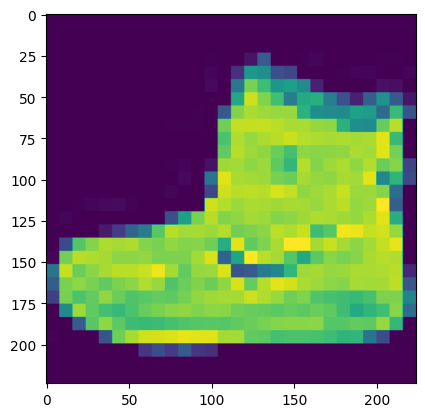

In [11]:
model.eval()
score = 0
for x, y in test_dataloader:
  score += acc_fn(model(x.to(device)).detach().cpu(), y)
print(score)

In [29]:
model.eval()
score = 0
BS = 32
for i in range(0, 10_000-BS, BS):
    model(X_test[i:i+BS].to(device))
    score += acc_fn(model(X_test[i:i+BS].to(device)), Y_test[i:i+BS].to(device)).item()
print(score / len(Y_test) * 100.0)
print(score, "/", len(Y_test))

84.59
8459 / 10000
